# Import Libraries

In [137]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from scipy.stats import shapiro, skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer


# Reading in dengue data and processing

## Read in cases data

In [138]:
data_jkt = pd.read_csv("../data/raw/jakarta_data.csv")
data_java = pd.read_csv("../data/raw/westjava_data.csv")

In [139]:
#rename time to year
data_java.rename(columns={'Time': 'Year'}, inplace=True)
data_jkt.rename(columns={'Time': 'Year'}, inplace=True)

In [140]:
#add Province column to identify the provinces of DKI Jakarta and West Java
data_java["Province"] = "Jawa Barat"
data_jkt["Province"] = "DKI Jakarta"

In [141]:
data_java.head()

,District,Year,Age,Cases,Population,Province
0,BANDUNG,2020,0-4,332,313554,Jawa Barat
1,BANDUNG,2020,15-44,950,1772345,Jawa Barat
2,BANDUNG,2020,45-99,312,892491,Jawa Barat
3,BANDUNG,2020,5-14,701,645400,Jawa Barat
4,BANDUNG,2021,0-4,470,311231,Jawa Barat


In [142]:
data_jkt.head()

,District,Year,Age,Cases,Population,Province
0,KEPULAUAN SERIBU,2020,0-4,9,2837,DKI Jakarta
1,KEPULAUAN SERIBU,2020,10-14,1,2307,DKI Jakarta
2,KEPULAUAN SERIBU,2020,15-19,0,2575,DKI Jakarta
3,KEPULAUAN SERIBU,2020,20-44,2,11456,DKI Jakarta
4,KEPULAUAN SERIBU,2020,45-54,0,3184,DKI Jakarta


In [143]:
#check the unique values of Distric for the jkt dataset
data_jkt["District"].nunique()

6

In [144]:
#check the unique values of Distric for the java dataset
data_java["District"].nunique()

27

In [145]:
# Get unique values from each dataset
districts_jkt = data_jkt["District"].unique()
districts_java = data_java["District"].unique()

# Combine them into a single list
combined_districts = list(set(districts_jkt) | set(districts_java))
combined_districts_filtered = [d for d in combined_districts if d != "KEPULAUAN SERIBU"]

In [146]:
#check the unique values for year for jkt
data_jkt["Year"].unique()

array([2020, 2021, 2022, 2023])

In [147]:
#check the unique values for year for java
data_java["Year"].unique()

array([2020, 2021, 2022, 2023])

## total area data processing for jkt

In [148]:
#read in the total area data
area_jkt_old = pd.read_csv("../data/raw/total_area_jkt_2020.csv")
area_jkt_new = pd.read_csv("../data/raw/total_area_jkt_20212023.csv")

In [149]:
#check the files
area_jkt_old.head()

,Kab/Kota,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,The Total Area by Regency/ Municipality (Km&lt...,NaN,NaN
1,NaN,2018,2019.00,2020.00
2,Kep Seribu,8.7,10.18,10.18
3,Jakarta Selatan,141.27,154.32,154.32
4,Jakarta Timur,188.03,182.70,182.70


In [150]:
#check the files
area_jkt_new.head()

,Kab/Kota,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,The Total Area by Regency/ Municipality (Km&lt...,NaN,NaN
1,NaN,2021,2022.00,2023.00
2,Kep Seribu,10.18,10.73,10.73
3,Jakarta Selatan,154.32,144.94,144.94
4,Jakarta Timur,182.7,185.54,185.54


In [151]:
#data cleaning for old and new jkt files - values for the index 1 row to be colnames for cols 1-3, then eliminate the rows of index 0 and 1 --> area is in km^2
area_jkt_new.columns = area_jkt_new.iloc[1]
area_jkt_new = area_jkt_new.iloc[2:]
area_jkt_old.columns = area_jkt_old.iloc[1]
area_jkt_old = area_jkt_old.iloc[2:]

#rename the first column into District
area_jkt_new.rename(columns={np.nan: 'District'}, inplace=True)
area_jkt_old.rename(columns={np.nan: 'District'}, inplace=True)

In [152]:
area_jkt_old.head()

1,District,2018,2019.0,2020.0
2,Kep Seribu,8.7,10.18,10.18
3,Jakarta Selatan,141.27,154.32,154.32
4,Jakarta Timur,188.03,182.70,182.70
5,Jakarta Pusat,48.13,52.38,52.38
6,Jakarta Barat,129.54,124.44,124.44


In [153]:
area_jkt_new.head()

1,District,2021,2022.0,2023.0
2,Kep Seribu,10.18,10.73,10.73
3,Jakarta Selatan,154.32,144.94,144.94
4,Jakarta Timur,182.7,185.54,185.54
5,Jakarta Pusat,52.38,47.56,47.56
6,Jakarta Barat,124.44,125.00,125.00


In [154]:
#merge both dataframew by District, and then convert to long form, then filter to get Year = 2020-2023 only
area_jkt = pd.merge(area_jkt_old, area_jkt_new, on="District", how="inner")
area_jkt = pd.melt(area_jkt, id_vars=["District"], var_name="Year", value_name="Area_sq_km")

#convert Year to integer
area_jkt["Year"] = area_jkt["Year"].astype(int)

#filter to get 2020-2023 values
area_jkt = area_jkt[area_jkt["Year"].isin([2020, 2021, 2022, 2023])]

#convert the names of District values to upper case
area_jkt["District"] = area_jkt["District"].str.upper()

#rename the value KEP SERIBU into KEPULAUAN SERIBU and add KOTA in front of the other values under the column District
area_jkt["District"] = "KOTA " + area_jkt["District"]
area_jkt.loc[area_jkt["District"] == "KOTA KEP SERIBU", "District"] = "KEPULAUAN SERIBU"

#convert the area values to float
area_jkt["Area_sq_km"] = area_jkt["Area_sq_km"].astype(float)

In [155]:
#check df
area_jkt.head()

,District,Year,Area_sq_km
14,KEPULAUAN SERIBU,2020,10.18
15,KOTA JAKARTA SELATAN,2020,154.32
16,KOTA JAKARTA TIMUR,2020,182.70
17,KOTA JAKARTA PUSAT,2020,52.38
18,KOTA JAKARTA BARAT,2020,124.44


In [156]:
area_jkt["District"].nunique()

7

In [157]:
#check unique values for Year
area_jkt["Year"].unique()

array([2020, 2021, 2022, 2023])

In [158]:
#check for duplicates
area_jkt.duplicated(subset=['District', 'Year']).sum()

np.int64(0)

In [159]:
#check for duplicates too
area_jkt = area_jkt.drop_duplicates(subset=['District', 'Year'])


## total area data processing for west java

In [160]:
area_java = pd.read_csv("../data/raw/total_area_westjava.csv")

area_java.head()

,Regency/Municipality,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Total Area (sq. km),NaN,NaN,NaN
1,NaN,2022,2021.00,2019.00,2018.00
2,Jawa Barat Province,35377.76,35377.76,35377.76,35377.76
3,Bogor,2710.62,2710.62,2710.62,2710.62
4,Sukabumi,4145.7,4145.70,4145.70,4145.70


In [161]:
#make the values for row index 1 become column values
area_java.columns = area_java.iloc[1]
area_java = area_java.iloc[2:]

#rename the col 1 to be "District" instead of NaN
area_java.rename(columns={np.nan: 'District'}, inplace=True)

#reformat to long
area_java = pd.melt(area_java, id_vars=["District"], var_name="Year", value_name="Area_sq_km")

#eliminate the Year column here because all the area values are the same
area_java = area_java.drop(columns=["Year"])

#convert the names of District values to upper case
area_java["District"] = area_java["District"].str.upper()

#rewrite municipality to kota at the front
area_java.loc[area_java["District"].str.contains("MUNICIPALITY"), "District"] = (
    "KOTA " + area_java["District"].str.replace("MUNICIPALITY", "").str.strip()
)

#convert the area values to float
area_java["Area_sq_km"] = area_java["Area_sq_km"].astype(float)

#check the dataframe format
area_java.head()

,District,Area_sq_km
0,JAWA BARAT PROVINCE,35377.76
1,BOGOR,2710.62
2,SUKABUMI,4145.70
3,CIANJUR,3840.16
4,BANDUNG,1767.96


In [162]:
area_java["District"].unique()

array(['JAWA BARAT PROVINCE', 'BOGOR', 'SUKABUMI', 'CIANJUR', 'BANDUNG',
       'GARUT', 'TASIKMALAYA', 'CIAMIS', 'KUNINGAN', 'CIREBON',
       'MAJALENGKA', 'SUMEDANG', 'INDRAMAYU', 'SUBANG', 'PURWAKARTA',
       'KARAWANG', 'BEKASI', 'BANDUNG BARAT', 'PANGANDARAN', 'KOTA BOGOR',
       'KOTA SUKABUMI', 'KOTA BANDUNG', 'KOTA CIREBON', 'KOTA BEKASI',
       'KOTA DEPOK', 'KOTA CIMAHI', 'KOTA TASIKMALAYA', 'KOTA BANJAR'],
      dtype=object)

In [163]:
#check for duplicates
area_java.duplicated(subset=['District']).sum()

np.int64(84)

In [164]:
area_java = area_java.drop_duplicates(subset=['District'])

In [165]:
area_java["Area_sq_km"].isnull().sum()

np.int64(0)

In [166]:
data_java.head()

,District,Year,Age,Cases,Population,Province
0,BANDUNG,2020,0-4,332,313554,Jawa Barat
1,BANDUNG,2020,15-44,950,1772345,Jawa Barat
2,BANDUNG,2020,45-99,312,892491,Jawa Barat
3,BANDUNG,2020,5-14,701,645400,Jawa Barat
4,BANDUNG,2021,0-4,470,311231,Jawa Barat


In [167]:
#merge the jkt and java datasets to the df_long dataset by District and Year to add the population density column
data_java = data_java.merge(area_java, on=["District"], how="left")
data_jkt = data_jkt.merge(area_jkt, on=["District", "Year"], how="left")

In [168]:
data_java.head()

,District,Year,Age,Cases,Population,Province,Area_sq_km
0,BANDUNG,2020,0-4,332,313554,Jawa Barat,1767.96
1,BANDUNG,2020,15-44,950,1772345,Jawa Barat,1767.96
2,BANDUNG,2020,45-99,312,892491,Jawa Barat,1767.96
3,BANDUNG,2020,5-14,701,645400,Jawa Barat,1767.96
4,BANDUNG,2021,0-4,470,311231,Jawa Barat,1767.96


In [169]:
#check missing values?
data_java['Area_sq_km'].isnull().sum()

np.int64(0)

In [170]:
data_jkt.head()

,District,Year,Age,Cases,Population,Province,Area_sq_km
0,KEPULAUAN SERIBU,2020,0-4,9,2837,DKI Jakarta,10.18
1,KEPULAUAN SERIBU,2020,10-14,1,2307,DKI Jakarta,10.18
2,KEPULAUAN SERIBU,2020,15-19,0,2575,DKI Jakarta,10.18
3,KEPULAUAN SERIBU,2020,20-44,2,11456,DKI Jakarta,10.18
4,KEPULAUAN SERIBU,2020,45-54,0,3184,DKI Jakarta,10.18


In [171]:
#check no of districts
data_java['District'].nunique()


27

In [172]:
data_jkt["District"].nunique()

6

In [173]:
#convert population and area to integer
data_java["Population"] = data_java["Population"].astype(int)
data_jkt["Population"] = data_jkt["Population"].astype(int)

#convert the area_sq_km values into
data_java["Area_sq_km"] = data_java["Area_sq_km"].astype(float)
data_jkt["Area_sq_km"] = data_jkt["Area_sq_km"].astype(float)
data_java["Pop_den"] = data_java["Population"] / data_java["Area_sq_km"]
data_jkt["Pop_den"] = data_jkt["Population"] / data_jkt["Area_sq_km"]

In [174]:
data_jkt.head()

,District,Year,Age,Cases,Population,Province,Area_sq_km,Pop_den
0,KEPULAUAN SERIBU,2020,0-4,9,2837,DKI Jakarta,10.18,278.683694
1,KEPULAUAN SERIBU,2020,10-14,1,2307,DKI Jakarta,10.18,226.620825
2,KEPULAUAN SERIBU,2020,15-19,0,2575,DKI Jakarta,10.18,252.946955
3,KEPULAUAN SERIBU,2020,20-44,2,11456,DKI Jakarta,10.18,1125.343811
4,KEPULAUAN SERIBU,2020,45-54,0,3184,DKI Jakarta,10.18,312.770138


In [175]:
#check unique values for year
data_java["Year"].unique()

array([2020, 2021, 2022, 2023])

In [176]:
#check unique values for year
data_jkt["Year"].unique()

array([2020, 2021, 2022, 2023])

In [177]:
#read in HDI data
data_hdi_old = pd.read_csv("../data/raw/hdi_2019-2021.csv")
data_hdi_new = pd.read_csv("../data/raw/hdi_2022-2024.csv")

In [178]:
data_hdi_old.head()

,Province/Regency/City,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,[New Method] Human Development Index,NaN,NaN
1,NaN,2019,2020,2021
2,ACEH,71.9,71.99,72.18
3,Simeulue,65.7,66.03,66.41
4,Aceh Singkil,68.91,68.94,69.22


In [179]:
data_hdi_new.head()

,Province/Regency/City,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,[New Method] Human Development Index,NaN,NaN
1,NaN,2022,2023,2024
2,ACEH,72.8,73.4,74.03
3,Simeulue,67.27,68.06,69.01
4,Aceh Singkil,69.62,70.14,70.75


In [180]:
#the colnames of the index 1 row to be colnames
data_hdi_new.columns = data_hdi_new.iloc[1]
data_hdi_new = data_hdi_new.iloc[2:]
data_hdi_old.columns = data_hdi_old.iloc[1]
data_hdi_old = data_hdi_old.iloc[2:]
#rename the first column to "District"
data_hdi_new.rename(columns={np.nan: 'District'}, inplace=True)
data_hdi_old.rename(columns={np.nan: 'District'}, inplace=True)

In [181]:
data_hdi_old.head()

1,District,2019,2020,2021
2,ACEH,71.9,71.99,72.18
3,Simeulue,65.7,66.03,66.41
4,Aceh Singkil,68.91,68.94,69.22
5,Aceh Selatan,66.9,67.12,67.44
6,Aceh Tenggara,69.36,69.37,69.44


In [182]:
data_hdi_new.head()

1,District,2022,2023,2024
2,ACEH,72.8,73.4,74.03
3,Simeulue,67.27,68.06,69.01
4,Aceh Singkil,69.62,70.14,70.75
5,Aceh Selatan,67.87,68.44,69.1
6,Aceh Tenggara,70.32,71.05,71.7


In [183]:
#concat by district
data_hdi = pd.merge(data_hdi_new, data_hdi_old, on=["District"], how="inner")

In [184]:
#check head for combined data_hdi
data_hdi.head()

1,District,2022,2023,2024,2019,2020,2021
0,ACEH,72.8,73.4,74.03,71.9,71.99,72.18
1,Simeulue,67.27,68.06,69.01,65.7,66.03,66.41
2,Aceh Singkil,69.62,70.14,70.75,68.91,68.94,69.22
3,Aceh Selatan,67.87,68.44,69.1,66.9,67.12,67.44
4,Aceh Tenggara,70.32,71.05,71.7,69.36,69.37,69.44


In [185]:
#pivot to long from wide
data_hdi = pd.melt(data_hdi, id_vars=["District"], var_name="Year", value_name="HDI")

#check
data_hdi.head()

,District,Year,HDI
0,ACEH,2022,72.8
1,Simeulue,2022,67.27
2,Aceh Singkil,2022,69.62
3,Aceh Selatan,2022,67.87
4,Aceh Tenggara,2022,70.32


In [186]:
#check unique values for Year
data_hdi["Year"].unique()

array(['2022', '2023', '2024', '2019', '2020', '2021'], dtype=object)

In [187]:
#rename Kep.Seribu into kepulauan seribu
data_hdi.loc[data_hdi["District"] == "Kep. Seribu", "District"] = "Kepulauan Seribu"

#convert the values of District column into all upper case
data_hdi["District"] = data_hdi["District"].str.upper()

#check again

data_hdi.head()

,District,Year,HDI
0,ACEH,2022,72.8
1,SIMEULUE,2022,67.27
2,ACEH SINGKIL,2022,69.62
3,ACEH SELATAN,2022,67.87
4,ACEH TENGGARA,2022,70.32


In [188]:
#convert Year to integer
data_hdi["Year"] = data_hdi["Year"].astype(int)

In [189]:
#merge the hdi data with the data_java and data_jakarta
data_java = data_java.merge(data_hdi, on=["District", "Year"], how="left")
data_jkt = data_jkt.merge(data_hdi, on=["District", "Year"], how="left")

In [190]:
#check
data_java.head()

,District,Year,Age,Cases,Population,Province,Area_sq_km,Pop_den,HDI
0,BANDUNG,2020,0-4,332,313554,Jawa Barat,1767.96,177.353560,72.39
1,BANDUNG,2020,15-44,950,1772345,Jawa Barat,1767.96,1002.480260,72.39
2,BANDUNG,2020,45-99,312,892491,Jawa Barat,1767.96,504.814023,72.39
3,BANDUNG,2020,5-14,701,645400,Jawa Barat,1767.96,365.053508,72.39
4,BANDUNG,2021,0-4,470,311231,Jawa Barat,1767.96,176.039616,72.73


In [191]:
data_jkt.head()

,District,Year,Age,Cases,Population,Province,Area_sq_km,Pop_den,HDI
0,KEPULAUAN SERIBU,2020,0-4,9,2837,DKI Jakarta,10.18,278.683694,71.63
1,KEPULAUAN SERIBU,2020,10-14,1,2307,DKI Jakarta,10.18,226.620825,71.63
2,KEPULAUAN SERIBU,2020,15-19,0,2575,DKI Jakarta,10.18,252.946955,71.63
3,KEPULAUAN SERIBU,2020,20-44,2,11456,DKI Jakarta,10.18,1125.343811,71.63
4,KEPULAUAN SERIBU,2020,45-54,0,3184,DKI Jakarta,10.18,312.770138,71.63


In [192]:
#check values of Year
data_java["Year"].unique()

array([2020, 2021, 2022, 2023])

In [193]:
#check
data_jkt.head()

,District,Year,Age,Cases,Population,Province,Area_sq_km,Pop_den,HDI
0,KEPULAUAN SERIBU,2020,0-4,9,2837,DKI Jakarta,10.18,278.683694,71.63
1,KEPULAUAN SERIBU,2020,10-14,1,2307,DKI Jakarta,10.18,226.620825,71.63
2,KEPULAUAN SERIBU,2020,15-19,0,2575,DKI Jakarta,10.18,252.946955,71.63
3,KEPULAUAN SERIBU,2020,20-44,2,11456,DKI Jakarta,10.18,1125.343811,71.63
4,KEPULAUAN SERIBU,2020,45-54,0,3184,DKI Jakarta,10.18,312.770138,71.63


In [194]:
#check values for year
data_jkt["Year"].unique()

array([2020, 2021, 2022, 2023])

In [195]:
data_java["District"].nunique()

27

In [196]:
data_jkt["District"].nunique()

6

# Read in shp file for Indonesia

## (district-level)

In [197]:
df_shp_dist = gpd.read_file("../data/raw/adm2.shp")

In [198]:
df_shp_dist["ADM1_EN"].unique()

array(['Aceh', 'Sumatera Barat', 'Nusa Tenggara Timur', 'Sumatera Utara',
       'Papua', 'Bali', 'Kalimantan Selatan', 'Jawa Barat',
       'Sulawesi Tengah', 'Kepulauan Bangka Belitung', 'Jawa Timur',
       'Jawa Tengah', 'Sulawesi Selatan', 'Daerah Istimewa Yogyakarta',
       'Sumatera Selatan', 'Kalimantan Tengah', 'Jambi', 'Riau',
       'Kalimantan Barat', 'Bengkulu', 'Kalimantan Timur',
       'Nusa Tenggara Barat', 'Kepulauan Riau', 'Gorontalo',
       'Sulawesi Utara', 'Sulawesi Tenggara', 'Kalimantan Utara',
       'Maluku', 'Lampung', 'Papua Barat', 'Maluku Utara', 'Dki Jakarta',
       'Banten', 'Sulawesi Barat'], dtype=object)

In [199]:
df_shp_dist.columns

Index(['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN',
       'ADM0_PCODE', 'date', 'validOn', 'validTo', 'geometry'],
      dtype='object')

In [200]:
#replace Dki Jakarta with DKI Jakarta 
df_shp_dist.loc[df_shp_dist['ADM1_EN'] == 'Dki Jakarta', "ADM1_EN"] = 'DKI Jakarta'

#convert everyth to uppercase letter (the province and district cols)
df_shp_dist["ADM2_EN"] = df_shp_dist["ADM2_EN"].str.upper()

#rename ADM2_EN and ADM1_EN to District and Province respectively
df_shp_dist.rename(columns = {"ADM2_EN": "District", "ADM1_EN": "Province"}, inplace = True)


df_shp_dist = df_shp_dist[df_shp_dist["District"].isin(combined_districts)]
df_shp_dist_simulation = df_shp_dist[df_shp_dist["District"].isin(combined_districts_filtered)]

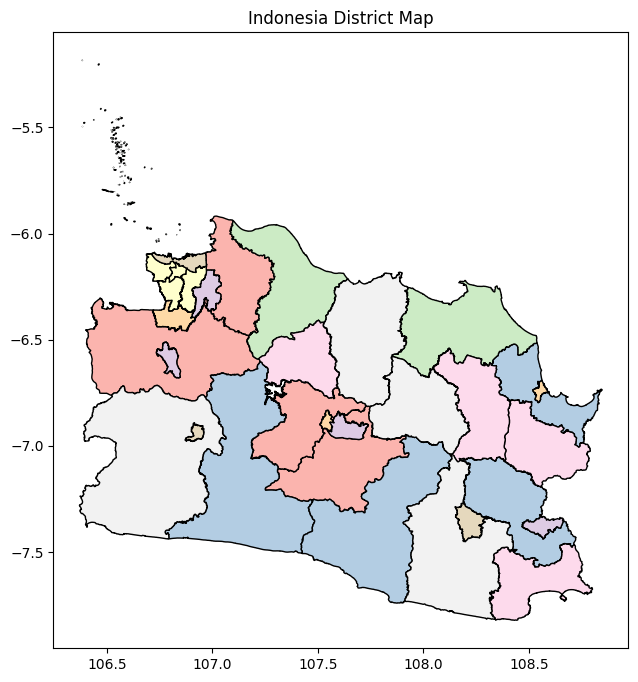

In [201]:
fig, ax = plt.subplots(figsize=(12, 8))
df_shp_dist.plot(ax=ax, edgecolor="black", cmap="Pastel1")

plt.title("Indonesia District Map")
plt.show()

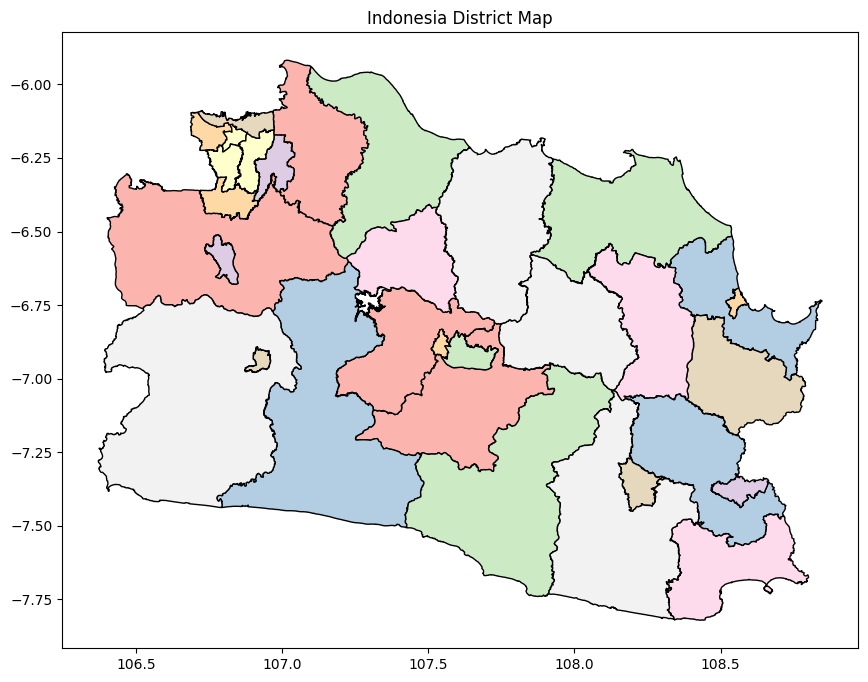

In [202]:
fig, ax = plt.subplots(figsize=(12, 8))
df_shp_dist_simulation.plot(ax=ax, edgecolor="black", cmap="Pastel1")

plt.title("Indonesia District Map")
plt.show()

In [203]:
print(df_shp_dist_simulation.columns)
print(df_shp_dist_simulation.dtypes)


Index(['Shape_Leng', 'Shape_Area', 'District', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1EN', 'ADM2ALT2EN', 'Province', 'ADM1_PCODE', 'ADM0_EN',
       'ADM0_PCODE', 'date', 'validOn', 'validTo', 'geometry'],
      dtype='object')
Shape_Leng           float64
Shape_Area           float64
District              object
ADM2_PCODE            object
ADM2_REF              object
ADM2ALT1EN            object
ADM2ALT2EN            object
Province              object
ADM1_PCODE            object
ADM0_EN               object
ADM0_PCODE            object
date          datetime64[ms]
validOn       datetime64[ms]
validTo               object
geometry            geometry
dtype: object


In [204]:
#get province level data by dissolving district level data without kepulauan seribu for the simulation study
df_shp_prov_simulation = df_shp_dist_simulation.dissolve(by="Province")


In [205]:
#must reset index
df_shp_prov_simulation = df_shp_prov_simulation.reset_index()

In [206]:
df_shp_prov_simulation

,Province,geometry,Shape_Leng,Shape_Area,District,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo
0,DKI Jakarta,"MULTIPOLYGON (((106.84094 -6.34198, 106.8407 -...",0.590340,0.010251,KOTA JAKARTA BARAT,ID3174,None,None,None,ID31,Indonesia,ID,2019-12-20,2020-04-01,0000/00/00
1,Jawa Barat,"MULTIPOLYGON (((107.42275 -7.50549, 107.42249 ...",3.093005,0.143607,BANDUNG,ID3204,None,None,None,ID32,Indonesia,ID,2019-12-20,2020-04-01,0000/00/00


## Province-Level

In [207]:
df_shp_prov = gpd.read_file("../data/raw/adm1.shp")

In [208]:
df_shp_prov.head()

,Shape_Leng,Shape_Area,ADM1_EN,ADM1_PCODE,ADM1_REF,ADM1ALT1EN,ADM1ALT2EN,ADM0_EN,ADM0_PCODE,date,validOn,validTo,geometry
0,27.367364,4.625437,Aceh,ID11,None,None,None,Indonesia,ID,2019-12-20,2020-04-01,0000/00/00,"MULTIPOLYGON (((97.39178 2.03748, 97.39055 2.0..."
1,6.026648,0.458717,Bali,ID51,None,None,None,Indonesia,ID,2019-12-20,2020-04-01,0000/00/00,"MULTIPOLYGON (((115.12509 -8.84761, 115.12499 ..."
2,9.279900,0.764911,Banten,ID36,None,None,None,Indonesia,ID,2019-12-20,2020-04-01,0000/00/00,"MULTIPOLYGON (((105.54977 -6.99566, 105.55035 ..."
3,11.653771,1.630129,Bengkulu,ID17,None,None,None,Indonesia,ID,2019-12-20,2020-04-01,0000/00/00,"MULTIPOLYGON (((102.38616 -5.47144, 102.38626 ..."
4,3.341561,0.260130,Daerah Istimewa Yogyakarta,ID34,None,None,None,Indonesia,ID,2019-12-20,2020-04-01,0000/00/00,"MULTIPOLYGON (((110.8198 -8.20358, 110.81951 -..."


In [209]:
print(df_shp_prov["ADM1_EN"].unique())  # Replace "shape1" with the suspected column name

['Aceh' 'Bali' 'Banten' 'Bengkulu' 'Daerah Istimewa Yogyakarta'
 'Dki Jakarta' 'Gorontalo' 'Jambi' 'Jawa Barat' 'Jawa Tengah' 'Jawa Timur'
 'Kalimantan Barat' 'Kalimantan Selatan' 'Kalimantan Tengah'
 'Kalimantan Timur' 'Kalimantan Utara' 'Kepulauan Bangka Belitung'
 'Kepulauan Riau' 'Lampung' 'Maluku' 'Maluku Utara' 'Nusa Tenggara Barat'
 'Nusa Tenggara Timur' 'Papua' 'Papua Barat' 'Riau' 'Sulawesi Barat'
 'Sulawesi Selatan' 'Sulawesi Tengah' 'Sulawesi Tenggara' 'Sulawesi Utara'
 'Sumatera Barat' 'Sumatera Selatan' 'Sumatera Utara']


In [210]:
#replace Dki Jakarta with DKI Jakarta 
df_shp_prov.loc[df_shp_prov['ADM1_EN'] == 'Dki Jakarta', 'ADM1_EN'] = 'DKI Jakarta'

#rename ADM2_EN and ADM1_EN to District and Province respectively
df_shp_prov.rename(columns = {"ADM1_EN": "Province"}, inplace = True)


#how to filter df_shp_prov such that it wld not include kepulauan seribu for the simulation study...
df_shp_prov = df_shp_prov[df_shp_prov["Province"].isin(["DKI Jakarta", "Jawa Barat"])]

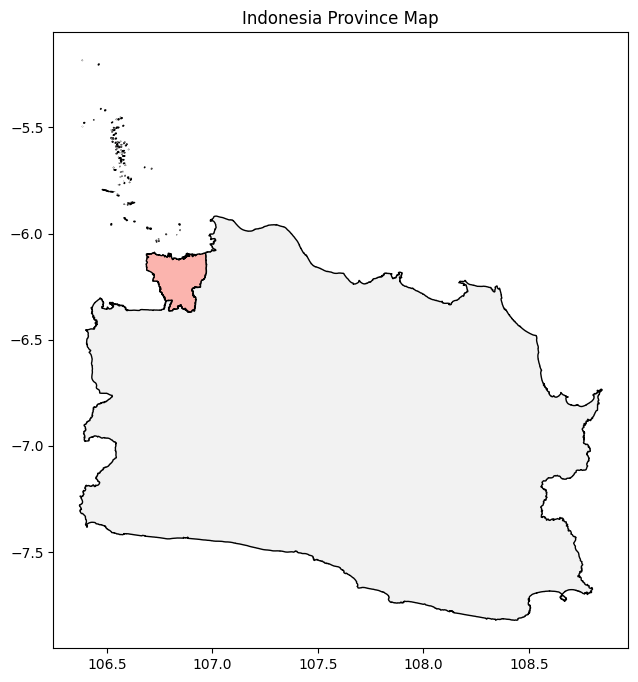

In [211]:
#try plotting
fig, ax = plt.subplots(figsize=(12, 8))
df_shp_prov.plot(ax=ax, edgecolor="black", cmap="Pastel1")

plt.title("Indonesia Province Map")
plt.show()

In [212]:
#check the namings for df_shp_dist and df_shp_prov
df_shp_dist['District'].unique()

array(['BANDUNG', 'BANDUNG BARAT', 'BEKASI', 'BOGOR', 'CIAMIS', 'CIANJUR',
       'CIREBON', 'GARUT', 'INDRAMAYU', 'KARAWANG', 'KEPULAUAN SERIBU',
       'KOTA BANDUNG', 'KOTA BANJAR', 'KOTA BEKASI', 'KOTA BOGOR',
       'KOTA CIMAHI', 'KOTA CIREBON', 'KOTA DEPOK', 'KOTA JAKARTA BARAT',
       'KOTA JAKARTA PUSAT', 'KOTA JAKARTA SELATAN', 'KOTA JAKARTA TIMUR',
       'KOTA JAKARTA UTARA', 'KOTA SUKABUMI', 'KOTA TASIKMALAYA',
       'KUNINGAN', 'MAJALENGKA', 'PANGANDARAN', 'PURWAKARTA', 'SUBANG',
       'SUKABUMI', 'SUMEDANG', 'TASIKMALAYA'], dtype=object)

# Tidy up the dengue data first into one final df

In [213]:
#combine the dengue data for both jkt and java
df_combined = pd.concat([data_java, data_jkt], ignore_index=True)

In [214]:
df_combined["District"].nunique()

33

In [215]:
df_combined.head()

,District,Year,Age,Cases,Population,Province,Area_sq_km,Pop_den,HDI
0,BANDUNG,2020,0-4,332,313554,Jawa Barat,1767.96,177.353560,72.39
1,BANDUNG,2020,15-44,950,1772345,Jawa Barat,1767.96,1002.480260,72.39
2,BANDUNG,2020,45-99,312,892491,Jawa Barat,1767.96,504.814023,72.39
3,BANDUNG,2020,5-14,701,645400,Jawa Barat,1767.96,365.053508,72.39
4,BANDUNG,2021,0-4,470,311231,Jawa Barat,1767.96,176.039616,72.73


In [216]:
#delete rows with redundant/repeated age groups --> we can take the interval of 9 years gap to avoid having too many groupings for age

#inconsistent age group intervals --> not a good way to stratify the data based on age group! can just combine the entire dataset to be of one age group for now
#for this --> eliminate redundant rows with age groups that are repeated --> 5-9, 10-14, 15-19, 20-44
df_combined = df_combined[~df_combined['Age'].isin(['5-9', '10-14', '15-19', '20-44', '45-54', '55-64', '65-74', '75-99'])]

In [217]:
df_combined["District"].unique()

array(['BANDUNG', 'BANDUNG BARAT', 'BEKASI', 'BOGOR', 'CIAMIS', 'CIANJUR',
       'CIREBON', 'GARUT', 'INDRAMAYU', 'KARAWANG', 'KOTA BANDUNG',
       'KOTA BANJAR', 'KOTA BEKASI', 'KOTA BOGOR', 'KOTA CIMAHI',
       'KOTA CIREBON', 'KOTA DEPOK', 'KOTA SUKABUMI', 'KOTA TASIKMALAYA',
       'KUNINGAN', 'MAJALENGKA', 'PANGANDARAN', 'PURWAKARTA', 'SUBANG',
       'SUKABUMI', 'SUMEDANG', 'TASIKMALAYA', 'KEPULAUAN SERIBU',
       'KOTA JAKARTA BARAT', 'KOTA JAKARTA PUSAT', 'KOTA JAKARTA SELATAN',
       'KOTA JAKARTA TIMUR', 'KOTA JAKARTA UTARA'], dtype=object)

In [218]:
df_combined[['District', 'Year', 'Area_sq_km', 'HDI', 'Province']].isnull().sum()

District      0
Year          0
Area_sq_km    0
HDI           0
Province      0
dtype: int64

In [219]:
#check the unique age grps again
df_combined['Age'].unique()

array(['0-4', '15-44', '45-99', '5-14'], dtype=object)

In [220]:
#now we merge the age groups together for each of the same District, Year, Area_sq_km, HDI --> need to sum Cases and Population metrics and the recalculate Pop_density
df_combined = df_combined.groupby(['District', 'Year', 'Area_sq_km', 'HDI', 'Province']).agg({'Cases': 'sum', 'Population': 'sum'}).reset_index()

#recalculate the Pop_density
df_combined['Pop_den'] = df_combined['Population'] / df_combined['Area_sq_km']

In [221]:
df_combined["District"].nunique()

33

In [222]:
#make sure that Year is integer, Area_sq_km is float, HDI is float, Cases, Population, Pop_density are numbers, and HDI is float
#check type of data first
df_combined.dtypes

District       object
Year            int64
Area_sq_km    float64
HDI            object
Province       object
Cases           int64
Population      int64
Pop_den       float64
dtype: object

In [223]:
#convert HDI into float, normalised
df_combined['HDI'] = df_combined['HDI'].astype(float) / 100

In [224]:
#aggregate for province level (with and without Kep Seribu)
#for province must aggregate first based on dki jakarta and west java (by province and year group by, sum the Cases and Population, take the mean for HDI, then recalculate population density)
df_combined_prov = df_combined.copy().groupby(["Province", "Year"]).agg({"Cases": "sum", "Population": "sum", "HDI": "mean", "Area_sq_km": "sum"}).reset_index()
df_combined_prov["Pop_den"] = df_combined_prov["Population"] / df_combined_prov["Area_sq_km"]

#for province must aggregate first based on dki jakarta and west java (by province and year group by, sum the Cases and Population, take the mean for HDI, then recalculate population density)
df_combined_prov_simulation = df_combined[df_combined["District"] != "KEPULAUAN SERIBU"].copy().groupby(["Province", "Year"]).agg({"Cases": "sum", "Population": "sum", "HDI": "mean", "Area_sq_km": "sum"}).reset_index()
df_combined_prov_simulation["Pop_den"] = df_combined_prov_simulation["Population"] / df_combined_prov_simulation["Area_sq_km"]

In [225]:
#separate the existing data into high-res (district-level) and low-res (province-level) data
df_combined_dist = df_combined.copy()
df_combined_dist_simulation = df_combined_dist[df_combined_dist["District"] != "KEPULAUAN SERIBU"]


In [226]:
#check number of districts
df_combined_dist["District"].nunique()

33

In [227]:
df_combined_dist_simulation["District"].nunique()

32

# Combine shp and dengue data

In [228]:
#combine shp file with dengue data district level
##aim: get a single shp file that contains ONLY the coordinates for Jawa and the districts within Jawa
data_dist = df_combined_dist.merge(df_shp_dist[["District", "Province", "geometry"]], on = ["District", "Province"], how = "left")
data_dist_simulation = df_combined_dist_simulation.merge(df_shp_dist_simulation[["District", "Province", "geometry"]], on = ["District", "Province"], how = "left")

In [229]:
#combine df_combined_prov w df_shp_prov by Province
data_prov = df_combined_prov.merge(df_shp_prov[["Province", "geometry"]], on = "Province", how = 'left')
data_prov_simulation = df_combined_prov_simulation.merge(df_shp_prov_simulation[["Province", "geometry"]], on = "Province", how = 'left')

In [230]:
# Ensure data_combined is a GeoDataFrame
df_dist = gpd.GeoDataFrame(data_dist, geometry='geometry')
df_dist_sim = gpd.GeoDataFrame(data_dist_simulation, geometry='geometry')
df_prov = gpd.GeoDataFrame(data_prov, geometry='geometry')
df_prov_sim = gpd.GeoDataFrame(data_prov_simulation, geometry='geometry')

In [231]:
df_dist["District"].nunique()

33

# Read in land cover data 

In [232]:
land_cover_java = gpd.read_file('../data/raw/Tuplah_Jawa_Barat_2019.shp')
land_cover_jkt = gpd.read_file('../data/raw/Tuplah_DKI_2019.shp')

In [233]:
land_cover_jkt.head()

,OBJECTID_1,NAME,Provinsi,PL_19_R,Legenda,geometry
0,33859,DKI Jakarta,DKI Jakarta,2007,Belukar,"POLYGON ((106.58462 -5.63406, 106.58552 -5.634..."
1,33860,DKI Jakarta,DKI Jakarta,2007,Belukar,"POLYGON ((106.57192 -5.62773, 106.57174 -5.627..."
2,33861,DKI Jakarta,DKI Jakarta,2012,Pemukiman,"POLYGON ((106.91438 -6.36541, 106.91436 -6.365..."
3,33862,DKI Jakarta,DKI Jakarta,2012,Pemukiman,"POLYGON ((106.91541 -6.36041, 106.91543 -6.360..."
4,33863,DKI Jakarta,DKI Jakarta,2012,Pemukiman,"POLYGON ((106.92073 -6.30023, 106.92075 -6.300..."


In [234]:
# 2. Reproject to a projected CRS (for accurate area calc)
# Let's use EPSG:32748 (UTM zone 48S, covers West Java)
districts = df_shp_dist.to_crs(epsg=32748)

province = df_shp_prov.to_crs(epsg=32748)

#combine land_cover for both jkt and java first
# 2. Ensure both are in the same CRS
if land_cover_java.crs != land_cover_jkt.crs:
    land_cover_jkt = land_cover_jkt.to_crs(land_cover_java.crs)

# 3. Concatenate
land_cover = pd.concat([land_cover_java, land_cover_jkt], ignore_index=True)
land_cover = land_cover.to_crs(epsg=32748)  # UTM Zone 48S, good for Java

In [235]:
#check land cover
land_cover.head()

,OBJECTID_1,NAME,Provinsi,PL_19_R,Legenda,geometry
0,468361,None,Jawa Barat,2014,Tanah Terbuka,"MULTIPOLYGON (((852047.644 9143954.444, 852047..."
1,468362,None,Jawa Barat,20091,Pertanian Lahan Kering,"MULTIPOLYGON (((863898.863 9135512.521, 863970..."
2,468363,None,Jawa Barat,2014,Tanah Terbuka,"MULTIPOLYGON (((854177.515 9140810.434, 854149..."
3,468364,None,Jawa Barat,20092,Pertanian Lahan Kering Campur,"MULTIPOLYGON (((884452.532 9136562.191, 884426..."
4,468365,None,Jawa Barat,2014,Tanah Terbuka,"MULTIPOLYGON (((854426.404 9140863.911, 854454..."


In [236]:
# drop OBJECTID_1 and NAME, conver Provinsi into Province, drop PL_19_R
# 1. Drop unnecessary columns
land_cover = land_cover.drop(columns=['OBJECTID_1', 'NAME', 'PL_19_R'])

# 2. Rename 'Provinsi' to 'Province'
land_cover = land_cover.rename(columns={'Provinsi': 'Province'})


In [237]:
#clip the landcover to only west java and jkt districts
land_cover_clipped_d = gpd.overlay(land_cover, districts, how='intersection')

C:\Users\jessi\AppData\Local\Temp\ipykernel_48760\1152055302.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 93 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  land_cover_clipped_d = gpd.overlay(land_cover, districts, how='intersection')


In [238]:
#check the land_cover_clipped_d districts
land_cover_clipped_d["District"].nunique()

33

In [239]:
districts["District"].nunique()

33

In [240]:
# 4. Calculate area of each polygon (in square meters)
land_cover_clipped_d['area_m2'] = land_cover_clipped_d.geometry.area

# 5. Group by district and land cover class
land_stats_d = (
    land_cover_clipped_d
    .groupby(['District', 'Legenda'])['area_m2']
    .sum()
    .reset_index()
    .pivot(index='District', columns='Legenda', values='area_m2')
    .fillna(0)
)

# 6. Optional: normalize to get proportion of each land cover type
land_stats_prop_d = land_stats_d.div(land_stats_d.sum(axis=1), axis=0)


In [241]:
# Unique land cover labels
land_cover['Legenda'].unique()


array(['Tanah Terbuka', 'Pertanian Lahan Kering',
       'Pertanian Lahan Kering Campur', 'Sawah', 'Tambak',
       'Bandara / Pelabuhan', 'Pertambangan', 'Rawa',
       'Hutan Lahan Kering Primer', 'Hutan Lahan Kering Sekunder',
       'Hutan Tanaman', 'Belukar', 'Perkebunan', 'Pemukiman', 'Badan Air',
       'Hutan Mangrove Sekunder', 'Belukar Rawa'], dtype=object)

In [242]:
#create an urbanicity score to reflect a proportion of total area that consists of urban activities
urban_classes = ['Pemukiman', 'Pertambangan', 'Bandara / Pelabuhan']

# Sum only urban land classes
urban_score_d = land_stats_prop_d[urban_classes].sum(axis=1)

# Add to your DataFrame
land_stats_prop_d['urbanicity'] = urban_score_d

In [243]:
land_stats_prop_d.head()

Legenda,Badan Air,Bandara / Pelabuhan,Belukar,Belukar Rawa,Hutan Lahan Kering Primer,Hutan Lahan Kering Sekunder,Hutan Mangrove Sekunder,Hutan Tanaman,Pemukiman,Perkebunan,Pertambangan,Pertanian Lahan Kering,Pertanian Lahan Kering Campur,Rawa,Sawah,Tambak,Tanah Terbuka,urbanicity
District,,,,,,,,,,,,,,,,,,
BANDUNG,0.002413,0.000327,0.003419,0.0,0.005046,0.120460,0.0,0.110542,0.122775,1.612644e-01,0.000053,0.244423,0.034802,0.0,0.183393,0.000000,0.011083,0.123155
BANDUNG BARAT,0.031275,0.000000,0.000067,0.0,0.000000,0.036206,0.0,0.365934,0.078207,5.663888e-02,0.000794,0.181323,0.147721,0.0,0.092684,0.000000,0.009150,0.079001
BEKASI,0.006806,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.288146,5.272687e-11,0.000000,0.036869,0.021319,0.0,0.541572,0.080928,0.024360,0.288146
BOGOR,0.003651,0.000184,0.000768,0.0,0.004294,0.116658,0.0,0.124915,0.161520,4.106269e-02,0.005509,0.173744,0.214167,0.0,0.149460,0.000000,0.004068,0.167212
CIAMIS,0.001940,0.000000,0.000507,0.0,0.004771,0.033939,0.0,0.072725,0.053804,1.970710e-02,0.000475,0.048580,0.586149,0.0,0.176931,0.000000,0.000472,0.054279


In [244]:
#convert District from index to column
land_stats_prop_d = land_stats_prop_d.reset_index()
land_stats_prop_d["District"].nunique()

33

In [245]:
# append District and urbanicity scores to the high-res data
df_dist = df_dist.merge(land_stats_prop_d[["District", "urbanicity"]], how = 'left', on = "District")
df_dist_sim = df_dist_sim.merge(land_stats_prop_d[["District", "urbanicity"]], how = 'left', on = "District")

In [246]:
df_dist.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,geometry,urbanicity
0,BANDUNG,2020,1767.96,0.7239,Jawa Barat,2295,3623790,2049.701351,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",0.123155
1,BANDUNG,2021,1767.96,0.7273,Jawa Barat,2002,3665655,2073.381185,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",0.123155
2,BANDUNG,2022,1767.96,0.7316,Jawa Barat,4191,3707523,2097.062716,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",0.123155
3,BANDUNG,2023,1767.96,0.7374,Jawa Barat,1005,3749391,2120.744248,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",0.123155
4,BANDUNG BARAT,2020,1305.77,0.6808,Jawa Barat,966,1788336,1369.564318,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",0.079001


In [247]:
df_dist["District"].nunique()

33

In [248]:
df_dist_sim["District"].nunique()

32

In [249]:
# Compute weighted sum of urbanicity per province
province_urbanicity = (
    df_dist
    .groupby('Province')
    .apply(lambda x: (x['urbanicity'] * x['Area_sq_km']).sum() / x['Area_sq_km'].sum())
    .reset_index(name='urbanicity')
)

C:\Users\jessi\AppData\Local\Temp\ipykernel_48760\1670720086.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['urbanicity'] * x['Area_sq_km']).sum() / x['Area_sq_km'].sum())


In [250]:
# Compute weighted sum of urbanicity per province excl. kep seribu
province_urbanicity_sim = (
    df_dist_sim
    .groupby('Province')
    .apply(lambda x: (x['urbanicity'] * x['Area_sq_km']).sum() / x['Area_sq_km'].sum())
    .reset_index(name='urbanicity')
)

C:\Users\jessi\AppData\Local\Temp\ipykernel_48760\3734788018.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['urbanicity'] * x['Area_sq_km']).sum() / x['Area_sq_km'].sum())


In [251]:
province_urbanicity.head()

,Province,urbanicity
0,DKI Jakarta,0.918091
1,Jawa Barat,0.095642


In [252]:
province_urbanicity_sim.head()

,Province,urbanicity
0,DKI Jakarta,0.931345
1,Jawa Barat,0.095642


In [253]:
#combine df_prov with land_stats_prov by Province
df_prov = df_prov.merge(province_urbanicity, on = "Province", how = 'left')
df_prov_sim = df_prov_sim.merge(province_urbanicity_sim, on = "Province", how = 'left')

### Variable transformation for full dataset (population density, HDI, urbanicity) to make sure that their distribution follows a gaussian process (for VAE to learn meaningful latent structures effectively)

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (140). n_quantiles is set to n_samples.
  warnings.warn(


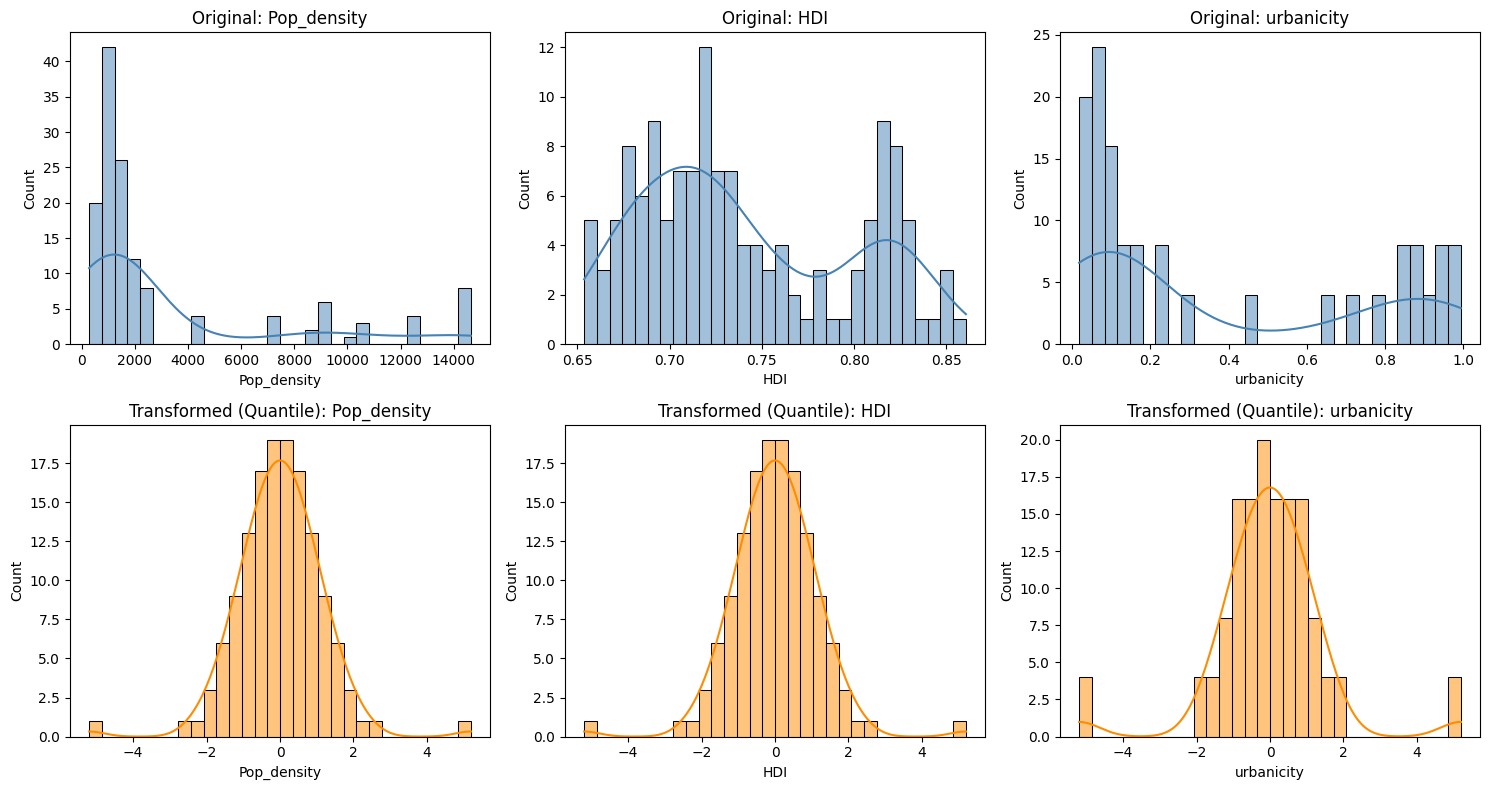

In [254]:
#concatenate Pop_density, HDI, and urbanicity columns from both df_prov and df_dist, and then visualise the dist to see if quantile transformation is needed

# 1. Concatenate province + district level features
pop_density_all = pd.concat([df_prov["Pop_den"], df_dist["Pop_den"]], ignore_index=True)
hdi_all = pd.concat([df_prov["HDI"], df_dist["HDI"]], ignore_index=True)
urbanicity_all = pd.concat([df_prov["urbanicity"], df_dist["urbanicity"]], ignore_index=True)

# 2. Combine into a DataFrame
combined_df = pd.DataFrame({
    "Pop_density": pop_density_all,
    "HDI": hdi_all,
    "urbanicity": urbanicity_all
})

# 3. Quantile transformation
qt = QuantileTransformer(output_distribution='normal', random_state=42)
transformed_data = qt.fit_transform(combined_df)
transformed_df = pd.DataFrame(transformed_data, columns=combined_df.columns)

# 4. Visualise original vs transformed
plt.figure(figsize=(15, 8))

for i, col in enumerate(combined_df.columns):
    # Original distribution
    plt.subplot(2, 3, i+1)
    sns.histplot(combined_df[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Original: {col}')
    
    # Transformed distribution
    plt.subplot(2, 3, i+4)
    sns.histplot(transformed_df[col], kde=True, bins=30, color='darkorange')
    plt.title(f'Transformed (Quantile): {col}')

plt.tight_layout()
plt.show()

In [255]:
# Check the column names in both dataframes
print(df_dist.columns)
print(df_prov.columns)

Index(['District', 'Year', 'Area_sq_km', 'HDI', 'Province', 'Cases',
       'Population', 'Pop_den', 'geometry', 'urbanicity'],
      dtype='object')
Index(['Province', 'Year', 'Cases', 'Population', 'HDI', 'Area_sq_km',
       'Pop_den', 'geometry', 'urbanicity'],
      dtype='object')


# Save final datasets

In [256]:
#save the dfs to high res and low res for further analysis
df_dist.to_file("../data/processed/high_res.shp")

#ensure df_prov is a geodataframe
df_prov.to_file("../data/processed/low_res.shp")

df_dist_sim.to_file("../simulation study/data/high_res_sim.shp")
df_prov_sim.to_file("../simulation study/data/low_res_sim.shp")